# Project

In [1]:
import numpy as np
import pandas as pd 
import math
from random import gauss
from math import sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log, sqrt, exp
from scipy.stats import norm
from glob import glob
import warnings
import os
from functools import reduce
warnings.filterwarnings("ignore")

# Data Acquisition and Cleaning - 10 years daily from NASDAQ 100 Technology Sector 

In [2]:
# function for reading files
def read_file(f):
    df = pd.read_csv(f)
    df['ticker'] = f.split('.')[0].strip('^')
    return df

# function for getting log-returns
def getlogret(data):
    logret = np.log(data) - np.log(data.shift(1))
    return logret

In [3]:
# create the dataframe for closing price, named as 'close'
close = pd.concat([read_file(f) for f in glob('*.csv')])
close = close.set_index(['Date','ticker'])[['Close']].unstack()
# extract the tickers for renaming purpose later
tickers = close.columns.get_level_values('ticker')
print(close)

                 Close                                                    \
ticker            AAPL        AMD        BIDU        GOOGL          IXIC   
Date                                                                       
2011-06-01   12.339643   8.370000  132.470001   263.063049   2769.189941   
2011-06-02   12.360714   8.240000  138.490005   264.294281   2773.310059   
2011-06-03   12.265714   7.970000  133.210007   261.801788   2732.780029   
2011-06-06   12.072857   7.800000  126.970001   260.790802   2702.560059   
2011-06-07   11.858571   7.710000  124.820000   259.774780   2701.560059   
...                ...        ...         ...          ...           ...   
2021-05-24  127.099998  77.440002  188.960007  2361.040039  13661.169922   
2021-05-25  126.900002  77.860001  192.770004  2362.870117  13657.169922   
2021-05-26  126.849998  78.339996  194.880005  2380.310059  13738.000000   
2021-05-27  125.279999  78.419998  194.809998  2362.679932  13736.280273   
2021-05-28  

In [4]:
# create the dataframe for logreturns, named as 'logret'
logret = close
for i in range(0,len(close.axes[1])):
    logret.iloc[:,i] = getlogret(close.iloc[:,i])
logret = logret.iloc[1:].rename(columns={'Close': 'Logret'})
print(logret)

              Logret                                                    \
ticker          AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                     
2011-06-02  0.001706 -0.015654  0.044442  0.004669  0.001487 -0.008633   
2011-06-03 -0.007715 -0.033316 -0.038871 -0.009475 -0.014722 -0.012882   
2011-06-06 -0.015848 -0.021561 -0.047976 -0.003869 -0.011120  0.004174   
2011-06-07 -0.017909 -0.011606 -0.017078 -0.003904 -0.000370  0.002080   
2011-06-08  0.000602 -0.011742 -0.033813  0.000270 -0.009738 -0.005000   
...              ...       ...       ...       ...       ...       ...   
2021-05-24  0.013226  0.003493 -0.003012  0.028749  0.014019  0.022624   
2021-05-25 -0.001575  0.005409  0.019962  0.000775 -0.000293  0.003741   
2021-05-26 -0.000394  0.006146  0.010886  0.007354  0.005901 -0.000914   
2021-05-27 -0.012454  0.001021 -0.000359 -0.007434 -0.000125 -0.008706   
2021-05-28 -0.005362  0.020947  0.0074

# Data Analysis - use the historical data to predict the future

## Volatility

In [5]:
# Define functions for actual/predicted volatility and the absolute error between them

def volpred(df, n):
    # keep the index for non-overlapped rolling window. eg for a=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], a[2::3]=[2, 5, 8]
    return (df.rolling(n).std()[n-1::n])*np.sqrt(260) # change to annualized volatility

def volerr(df, n):
    df_volpred = volpred(df, n) 
    df_volerr = (df_volpred.shift(-1) - df_volpred).rename(columns={'Logret': 'Residual Error (Volatility)'})
    df_volerr = df_volerr.iloc[:-1] # delete the last NaN row
    return df_volerr

def volabserr(df, n):
    df_volpred = volpred(df, n)
    df_volabserr = (df_volpred.shift(-1) - df_volpred).abs().rename(columns={'Logret': 'Absolute Error (Volatility)'})
    df_volabserr = df_volabserr.iloc[:-1] # delete the last NaN row
    return df_volabserr

In [6]:
# Define error functions, relative errors, taking size of error into account

def volAPE(df,n): # use absolute percentage error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volerr.columns = tickers
    df_volAPE = (df_volerr.div(df_volact.iloc[:-1])).abs() # abs((actual-pred)/actual) 
    df_volAPE.columns=pd.MultiIndex.from_product([['APE (Volatility)'], df_volAPE.columns])
    return df_volAPE

def volAMPE(df,n): # use absolute mean percentage error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volerr = (df_volpred - df_volact).iloc[:-1]  # delete the last NaN row
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volerr.columns = tickers
    avg = (df_volact.iloc[:-1] + df_volpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_volAMPE = (df_volerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_volAMPE.columns=pd.MultiIndex.from_product([['AMPE (Volatility)'], df_volAMPE.columns])
    return df_volAMPE

def volLAAR(df,n): # use log of absolute value of accuracy ratio as error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(-1)
    df_volpred.columns = tickers
    df_volact.columns = tickers
    df_volLAAR = np.log((df_volpred.iloc[:-1].div(df_volact.iloc[:-1])).abs()) # log(abs(pred/act)) 
    df_volLAAR.columns=pd.MultiIndex.from_product([['LAAR (Volatility)'], df_volLAAR.columns])
    return df_volLAAR


## Mean

In [7]:
# Define functions for actual/predicted mean and the absolute error between them

def meanpred(df, n):
    return (df.rolling(n).mean()[n-1::n])*260 # change to annualized mean

def meanerr(df, n):
    df_meanpred = meanpred(df, n)
    df_meanerr = (df_meanpred.shift(-1) - df_meanpred).rename(columns={'Logret': 'Residual Error (Mean)'})
    df_meanerr = df_meanerr.iloc[:-1] # delete the last NaN row
    return df_meanerr 

def meanabserr(df, n):
    df_meanpred = meanpred(df, n)
    df_meanabserr = (df_meanpred.shift(-1) - df_meanpred).abs().rename(columns={'Logret': 'Absolute Error (Mean)'})
    df_meanabserr = df_meanabserr.iloc[:-1] # delete the last NaN row
    return df_meanabserr

In [8]:
# Define error functions, relative errors, taking size of error into account

def meanAPE(df,n): # use absolute percentage error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanerr = (df_meanpred - df_meanact).iloc[:-1]  # delete the last NaN row
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanerr.columns = tickers
    df_meanAPE = (df_meanerr.div(df_meanact.iloc[:-1])).abs() # abs((actual-pred)/actual) 
    df_meanAPE.columns=pd.MultiIndex.from_product([['APE (Mean)'], df_meanAPE.columns])
    return df_meanAPE

def meanAMPE(df,n): # use absolute mean percentage error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanerr = (df_meanpred - df_meanact).iloc[:-1]  # delete the last NaN row
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanerr.columns = tickers
    avg = (df_meanact.iloc[:-1] + df_meanpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_meanAMPE = (df_meanerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_meanAMPE.columns=pd.MultiIndex.from_product([['AMPE (Mean)'], df_meanAMPE.columns])
    return df_meanAMPE

def meanLAAR(df,n): # use log of absolute value of accuracy ratio as error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(-1)
    df_meanpred.columns = tickers
    df_meanact.columns = tickers
    df_meanLAAR = np.log((df_meanpred.iloc[:-1].div(df_meanact.iloc[:-1])).abs()) # log(abs(pred/act)) 
    df_meanLAAR.columns=pd.MultiIndex.from_product([['LAAR (Mean)'], df_meanLAAR.columns])
    return df_meanLAAR

In [9]:
# define functions for plotting histogram and the numerical results
# given the error functions and a fixed timewindow
def plothist(function, tw):
    myerr = function(logret, tw)
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

### Iterate through the time window

In [10]:
# # define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail

# for volatility
def plotdot_vol(function, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations in tail
    percent = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        myerr = function(logret, i)
        
        # check infinity problem
        if myerr.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if myerr.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null
            
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = tickers # rename the columns as the securities
    dotvalue = print(percent_T)
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Volatility, Percentage of error observations outside tail={tail}, {str(function.__name__).strip('vol')}")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot

# for mean
def plotdot_mean(function, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations in tail
    percent = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf
    tw_null = [] # mark the timewindows for which the errors include NaN
    
    for i in range(tw1, tw2+step, step):
        myerr = function(logret, i)
        
        # check infinity problem
        if myerr.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf
        # check NaN problem
        if myerr.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null

        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = tickers # rename the columns as the securities
    dotvalue = print(percent_T)
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Mean, Percentage of error observations outside tail={tail}, {str(function.__name__).strip('mean')}")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot

## Compute results for volatility & mean

#### APE

           APE (Volatility)                                                    \
ticker                 AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                            
2011-09-09         0.098364  0.093842  0.030827  0.430445  0.158228  0.200445   
2011-12-19         0.261736  0.830093  0.503922  0.134644  1.284989  0.293238   
2012-03-30         0.309169  0.239281  0.092651  0.042137  0.336297  0.165205   
2012-07-11         0.458020  0.178211  0.158782  0.009849  0.464213  0.278649   
2012-10-18         0.489737  0.118379  0.127285  0.169130  0.094927  0.177406   
2013-02-01         0.533820  0.235148  0.063339  0.096974  0.087435  0.064764   
2013-05-14         0.218145  0.010491  0.020063  0.185422  0.084484  0.323507   
2013-08-22         0.053824  0.233971  0.081355  0.452595  0.027990  0.109660   
2013-12-02         0.010685  0.133242  0.072673  0.466750  0.077770  0.354638   
2014-03-14         0.146605 

(None,
 array([[<AxesSubplot:title={'center':"('APE (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('APE (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('APE (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('APE (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'TXN')"}>]],
       dtype=object))

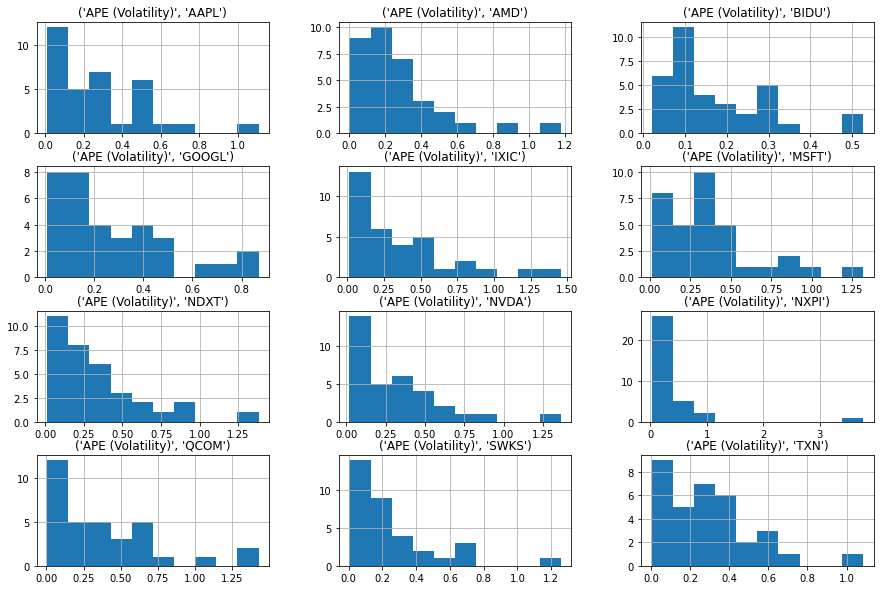

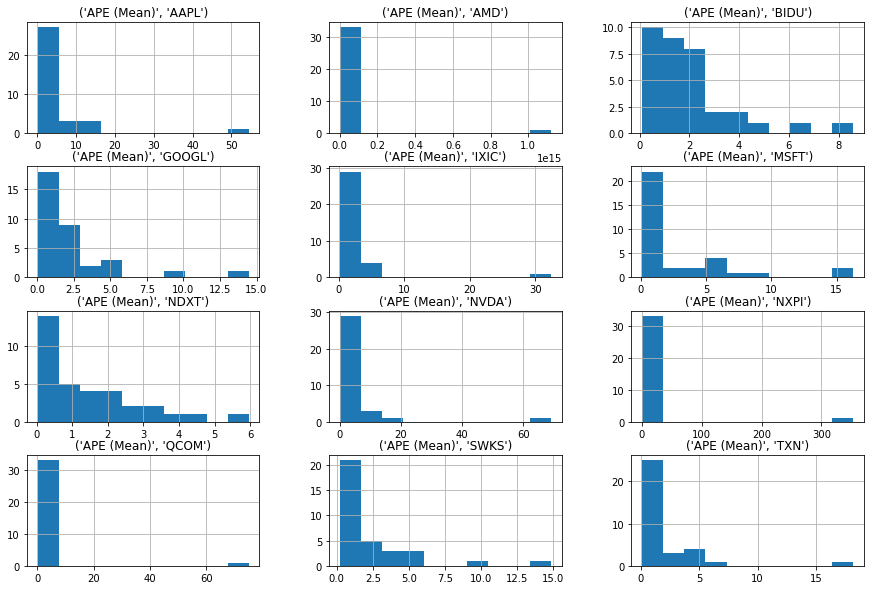

In [11]:
# histogram, tw = 70
plothist(volAPE, 70)
plothist(meanAPE, 70)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.900398  0.908367  0.888446  0.892430  0.890438  0.870518  0.882470   
10      0.844000  0.876000  0.860000  0.840000  0.848000  0.860000  0.848000   
15      0.831325  0.891566  0.801205  0.855422  0.867470  0.867470  0.837349   
20      0.862903  0.854839  0.774194  0.830645  0.846774  0.806452  0.806452   
25      0.878788  0.868687  0.808081  0.868687  0.797980  0.838384  0.828283   
30      0.865854  0.914634  0.768293  0.853659  0.829268  0.939024  0.804878   
35      0.728571  0.914286  0.742857  0.842857  0.742857  0.842857  0.800000   
40      0.852459  0.901639  0.704918  0.770492  0.786885  0.754098  0.770492   
45      0.833333  0.870370  0.740741  0.722222  0.703704  0.796296  0.796296   
50      0.755102  0.836735  0.632653  0.857143  0.755102  0.775510  0.795918   
55      0.795455  0.863636  0.659091  0.795455  0.795455  0.795455  0.772727   
60      0.775000  0.775000  0.650000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.1, APE'}>)

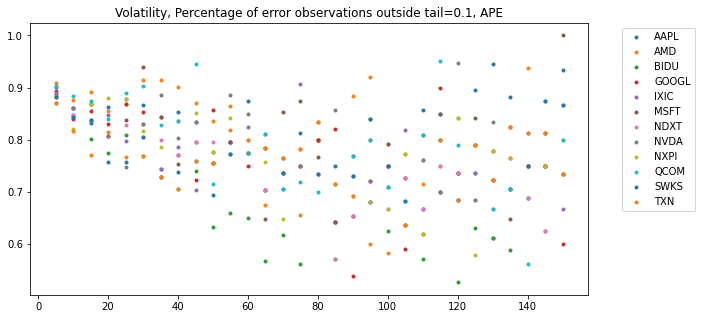

In [12]:
# dot plot, volatility, tail = 10%
plotdot_vol(volAPE, 5, 150, 5, 0.1)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.414343  0.476096  0.460159  0.430279  0.444223  0.438247  0.428287   
10      0.344000  0.352000  0.292000  0.264000  0.304000  0.344000  0.268000   
15      0.301205  0.319277  0.240964  0.277108  0.319277  0.301205  0.246988   
20      0.225806  0.298387  0.233871  0.241935  0.282258  0.306452  0.266129   
25      0.252525  0.282828  0.161616  0.303030  0.292929  0.323232  0.262626   
30      0.243902  0.280488  0.134146  0.182927  0.195122  0.207317  0.219512   
35      0.200000  0.257143  0.085714  0.200000  0.242857  0.214286  0.228571   
40      0.180328  0.147541  0.081967  0.163934  0.262295  0.213115  0.213115   
45      0.166667  0.185185  0.074074  0.240741  0.259259  0.240741  0.222222   
50      0.122449  0.142857  0.020408  0.183673  0.265306  0.244898  0.265306   
55      0.113636  0.113636  0.022727  0.159091  0.181818  0.136364  0.159091   
60      0.150000  0.225000  0.050000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.5, APE'}>)

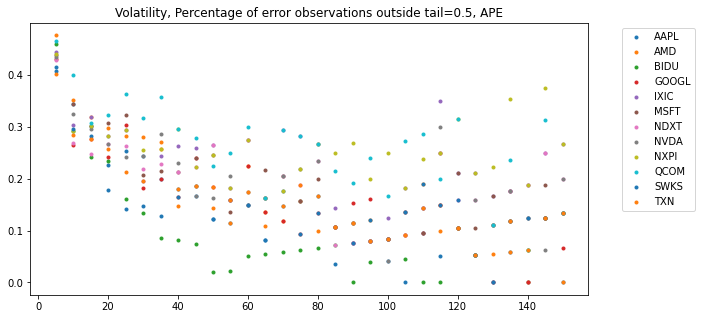

In [13]:
# dot plot, volatility, tail = 10%
plotdot_vol(volAPE, 5, 150, 5, 0.5)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
10       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
15       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
20       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
25       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
30       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
35       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
40       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
45       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
50       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
55       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
60       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=100, APE'}>)

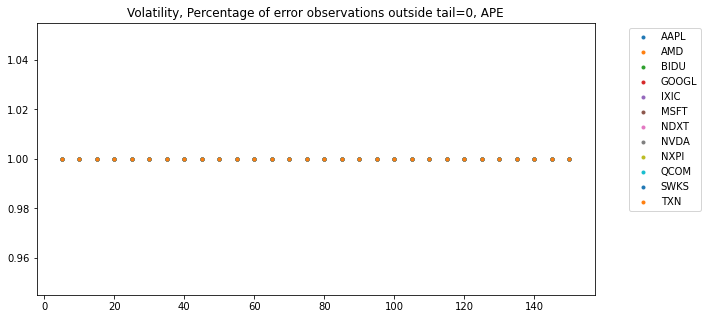

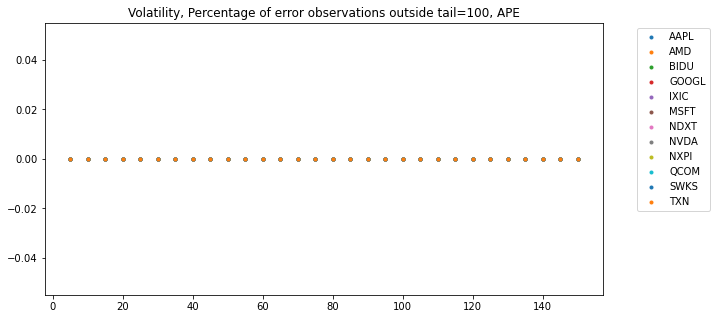

In [14]:
# dot plot, volatility, tail = 0, 100 (for checking)
plotdot_vol(volAPE, 5, 150, 5, 0)
plotdot_vol(volAPE, 5, 150, 5, 100)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.964143  0.968127  0.966135  0.972112  0.956175  0.980080  0.972112   
10      0.968000  0.960000  0.964000  0.968000  0.964000  0.976000  0.980000   
15      0.975904  0.951807  0.981928  0.975904  0.927711  0.981928  0.945783   
20      0.967742  0.951613  0.983871  0.959677  0.927419  0.935484  0.991935   
25      0.959596  0.989899  0.989899  0.959596  0.959596  0.969697  0.959596   
30      0.951220  0.914634  0.987805  0.975610  0.951220  0.975610  0.975610   
35      0.942857  0.957143  0.971429  0.985714  0.985714  0.928571  0.957143   
40      0.983607  0.983607  0.983607  0.934426  0.950820  0.983607  0.901639   
45      1.000000  1.000000  1.000000  0.925926  0.981481  0.981481  1.000000   
50      0.918367  0.959184  1.000000  0.979592  0.979592  0.918367  0.918367   
55      0.954545  0.977273  0.931818  0.931818  0.931818  0.931818  0.931818   
60      0.975000  0.950000  1.000000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.1, APE'}>)

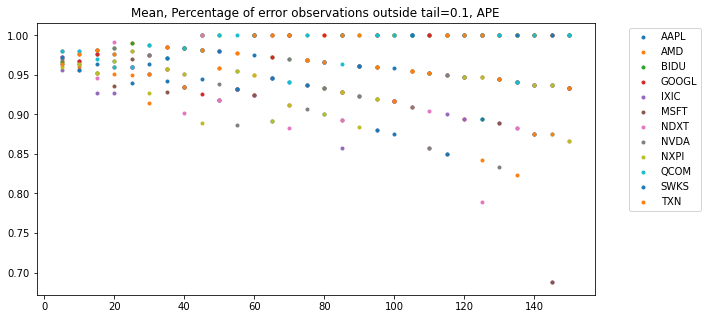

In [15]:
# dot plot, mean, tail = 10%
plotdot_mean(meanAPE, 5, 150, 5, 0.1)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.830677  0.830677  0.830677  0.834661  0.832669  0.838645  0.832669   
10      0.856000  0.804000  0.848000  0.840000  0.816000  0.852000  0.804000   
15      0.771084  0.831325  0.867470  0.861446  0.746988  0.813253  0.843373   
20      0.798387  0.822581  0.854839  0.830645  0.758065  0.830645  0.838710   
25      0.808081  0.808081  0.848485  0.818182  0.757576  0.787879  0.818182   
30      0.817073  0.829268  0.841463  0.841463  0.768293  0.841463  0.817073   
35      0.800000  0.800000  0.842857  0.857143  0.814286  0.728571  0.814286   
40      0.852459  0.721311  0.918033  0.836066  0.819672  0.770492  0.803279   
45      0.888889  0.833333  0.870370  0.796296  0.851852  0.833333  0.796296   
50      0.755102  0.816327  0.857143  0.836735  0.795918  0.795918  0.714286   
55      0.818182  0.795455  0.886364  0.818182  0.750000  0.818182  0.772727   
60      0.950000  0.925000  0.950000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.5, APE'}>)

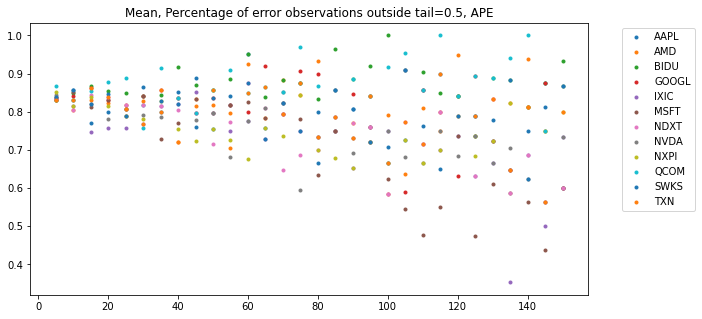

In [16]:
# dot plot, mean, tail = 50%
plotdot_mean(meanAPE, 5, 150, 5, 0.5)

ticker  AAPL       AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  \
5        1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
10       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
15       1.0  0.993976   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
20       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
25       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
30       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
35       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
40       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
45       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
50       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
55       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
60       1.0  1.000000   1.0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=100, APE'}>)

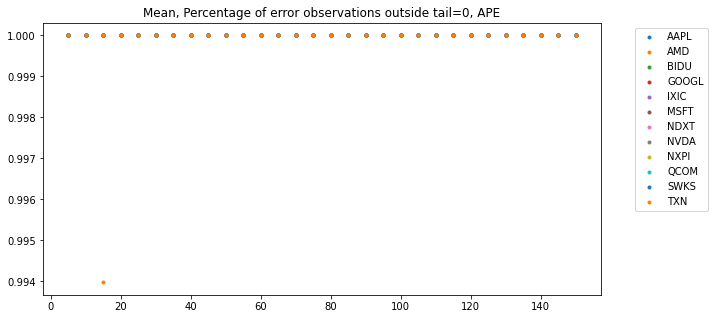

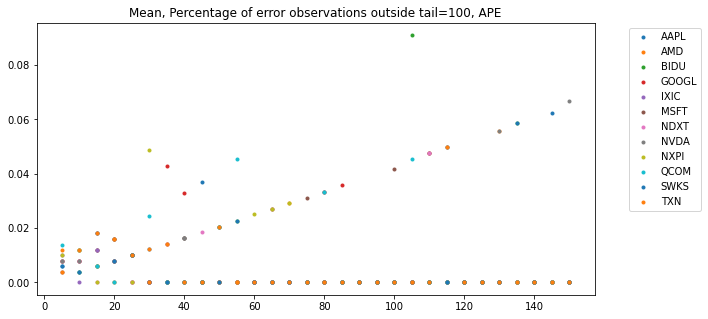

In [17]:
# dot plot, mean, tail = 0, 100 (for checking)
plotdot_mean(meanAPE, 5, 150, 5, 0)
plotdot_mean(meanAPE, 5, 150, 5, 100)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
10       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
15       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
20       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
25       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
30       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
35       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
40       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
45       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
50       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
55       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
60       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=inf, APE'}>)

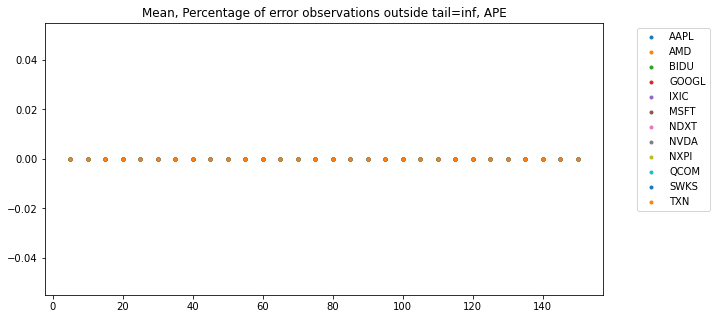

In [18]:
# dot plot, mean, tail = inf (for checking)
plotdot_mean(meanAPE, 5, 150, 5, math.inf)

#### AMPE

           AMPE (Volatility)                                          \
ticker                  AAPL       AMD      BIDU     GOOGL      IXIC   
Date                                                                   
2011-09-09          0.093753  0.098462  0.031309  0.354211  0.146628   
2011-12-19          0.231447  0.586619  0.402506  0.126151  0.782340   
2012-03-30          0.365700  0.271799  0.088549  0.041268  0.404276   
2012-07-11          0.372674  0.195644  0.172475  0.009898  0.376764   
2012-10-18          0.648545  0.125826  0.119669  0.155943  0.099658   
2013-02-01          0.421356  0.210409  0.065411  0.092489  0.083772   
2013-05-14          0.196691  0.010546  0.020266  0.169690  0.081060   
2013-08-22          0.055312  0.209467  0.078175  0.584973  0.028387   
2013-12-02          0.010629  0.124920  0.075413  0.378433  0.080917   
2014-03-14          0.136592  0.000032  0.062520  0.236119  0.079858   
2014-06-24          0.076858  0.068175  0.095629  0.323678  0.23

(None,
 array([[<AxesSubplot:title={'center':"('AMPE (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('AMPE (Mean)', 'TXN')"}>]],
       dtype=object))

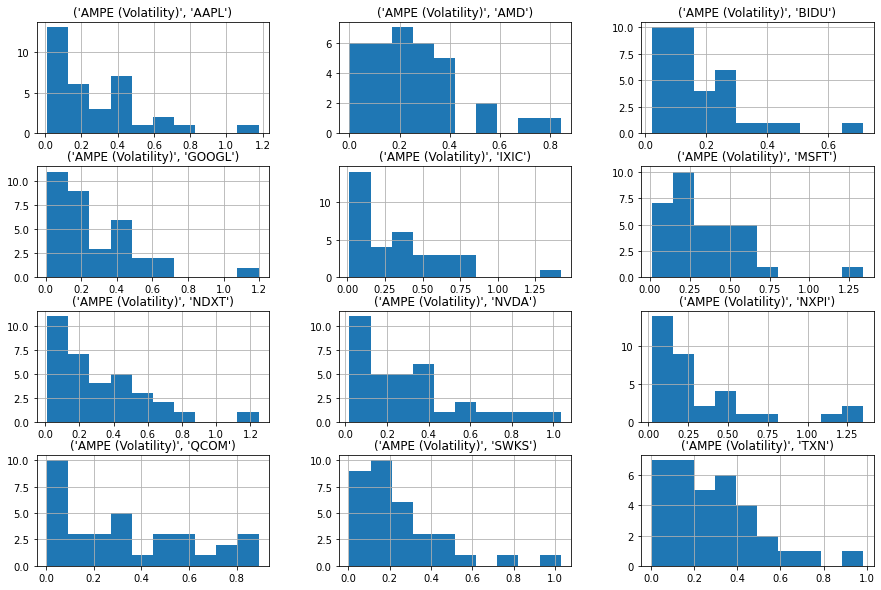

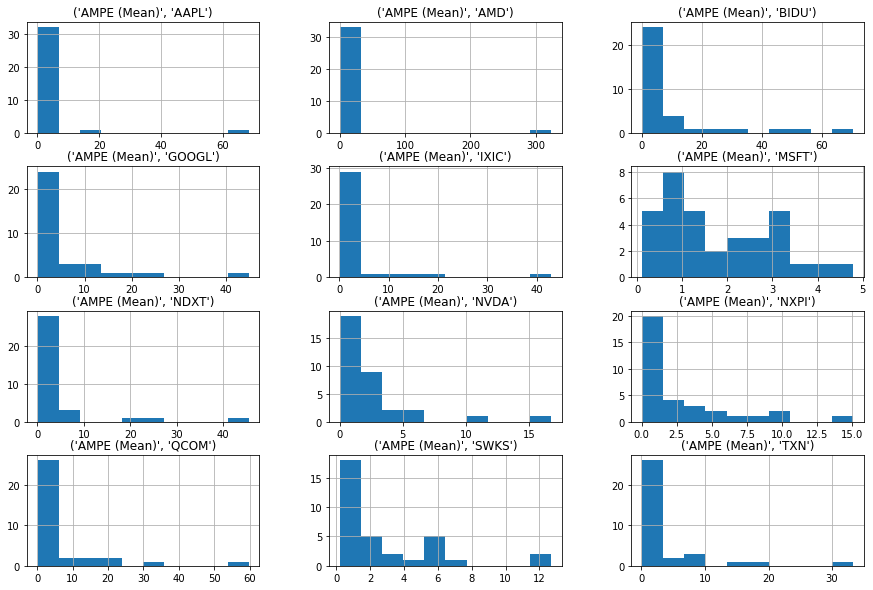

In [19]:
# histogram, tw = 70
plothist(volAMPE, 70)
plothist(meanAMPE, 70)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.902390  0.908367  0.890438  0.896414  0.894422  0.866534  0.878486   
10      0.848000  0.872000  0.868000  0.832000  0.852000  0.864000  0.848000   
15      0.837349  0.891566  0.801205  0.855422  0.879518  0.873494  0.831325   
20      0.854839  0.854839  0.782258  0.830645  0.846774  0.814516  0.806452   
25      0.878788  0.858586  0.787879  0.868687  0.808081  0.838384  0.828283   
30      0.865854  0.926829  0.768293  0.853659  0.829268  0.926829  0.792683   
35      0.728571  0.900000  0.742857  0.842857  0.728571  0.814286  0.800000   
40      0.852459  0.885246  0.721311  0.770492  0.770492  0.770492  0.770492   
45      0.851852  0.870370  0.759259  0.722222  0.722222  0.777778  0.777778   
50      0.755102  0.816327  0.632653  0.857143  0.775510  0.775510  0.795918   
55      0.795455  0.840909  0.681818  0.795455  0.795455  0.795455  0.750000   
60      0.750000  0.775000  0.650000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.1, AMPE'}>)

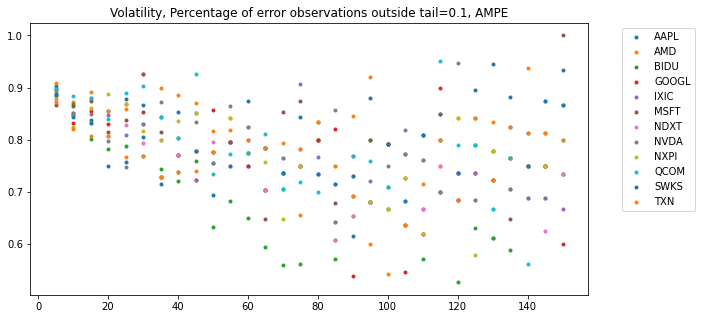

In [20]:
# dot plot, volatility, tail = 10%
plotdot_vol(volAMPE, 5, 150, 5, 0.1)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.434263  0.482072  0.507968  0.448207  0.460159  0.446215  0.420319   
10      0.360000  0.376000  0.260000  0.272000  0.300000  0.284000  0.280000   
15      0.343373  0.313253  0.253012  0.253012  0.301205  0.325301  0.301205   
20      0.241935  0.298387  0.241935  0.274194  0.274194  0.306452  0.209677   
25      0.262626  0.282828  0.191919  0.282828  0.292929  0.323232  0.272727   
30      0.158537  0.256098  0.121951  0.182927  0.170732  0.243902  0.195122   
35      0.171429  0.171429  0.057143  0.200000  0.214286  0.200000  0.242857   
40      0.180328  0.163934  0.065574  0.196721  0.213115  0.196721  0.229508   
45      0.240741  0.185185  0.055556  0.222222  0.240741  0.240741  0.222222   
50      0.204082  0.163265  0.061224  0.224490  0.224490  0.224490  0.244898   
55      0.136364  0.204545  0.068182  0.227273  0.181818  0.181818  0.204545   
60      0.175000  0.125000  0.050000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.5, AMPE'}>)

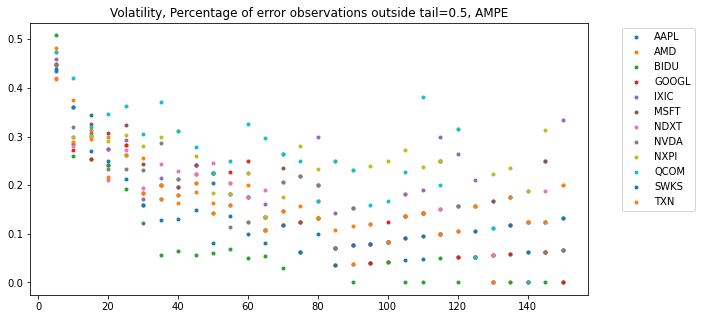

In [21]:
# dot plot, volatility, tail = 50%
plotdot_vol(volAMPE, 5, 150, 5, 0.5)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
10       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
15       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
20       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
25       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
30       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
35       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
40       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
45       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
50       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
55       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
60       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=100, AMPE'}>)

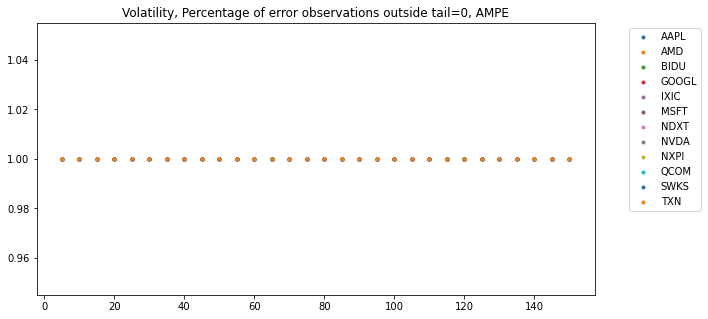

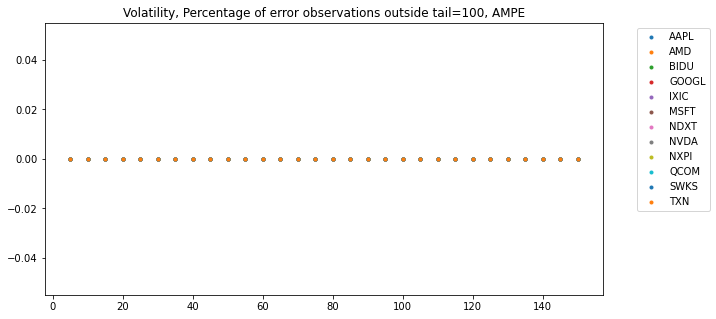

In [22]:
# dot plot, volatility, tail = 0, 100 (for checking)
plotdot_vol(volAMPE, 5, 150, 5, 0)
plotdot_vol(volAMPE, 5, 150, 5, 100)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.966135  0.968127  0.968127  0.972112  0.956175  0.978088  0.970120   
10      0.968000  0.968000  0.964000  0.964000  0.960000  0.976000  0.980000   
15      0.969880  0.957831  0.981928  0.975904  0.927711  0.981928  0.945783   
20      0.967742  0.951613  0.983871  0.959677  0.927419  0.943548  0.991935   
25      0.959596  0.989899  0.989899  0.959596  0.959596  0.969697  0.959596   
30      0.951220  0.914634  0.987805  0.975610  0.951220  0.975610  0.975610   
35      0.942857  0.957143  0.971429  0.985714  0.985714  0.928571  0.957143   
40      0.983607  0.983607  0.983607  0.934426  0.967213  0.983607  0.901639   
45      1.000000  1.000000  1.000000  0.925926  0.981481  0.981481  1.000000   
50      0.918367  0.979592  1.000000  0.979592  0.959184  0.959184  0.918367   
55      0.954545  0.977273  0.931818  0.931818  0.931818  0.931818  0.931818   
60      0.975000  0.950000  1.000000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.1, AMPE'}>)

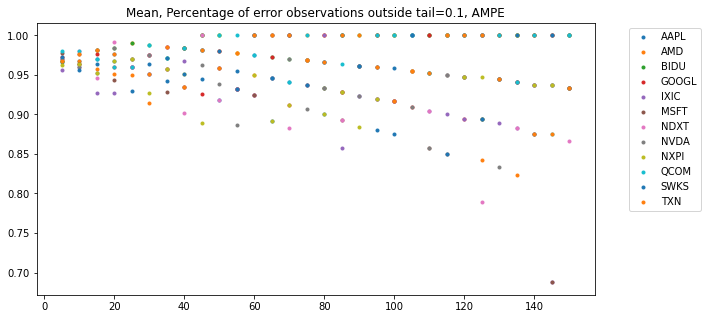

In [23]:
# dot plot, mean, tail = 10%
plotdot_mean(meanAMPE, 5, 150, 5, 0.1)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.854582  0.840637  0.828685  0.854582  0.838645  0.856574  0.842629   
10      0.868000  0.840000  0.844000  0.860000  0.820000  0.856000  0.804000   
15      0.795181  0.843373  0.891566  0.861446  0.722892  0.819277  0.837349   
20      0.838710  0.854839  0.862903  0.838710  0.766129  0.846774  0.854839   
25      0.838384  0.848485  0.858586  0.868687  0.767677  0.858586  0.828283   
30      0.804878  0.804878  0.829268  0.853659  0.768293  0.853659  0.841463   
35      0.785714  0.800000  0.757143  0.914286  0.842857  0.742857  0.871429   
40      0.885246  0.770492  0.901639  0.852459  0.868852  0.803279  0.836066   
45      0.888889  0.814815  0.851852  0.814815  0.870370  0.851852  0.814815   
50      0.734694  0.816327  0.857143  0.836735  0.816327  0.816327  0.714286   
55      0.818182  0.795455  0.863636  0.795455  0.750000  0.863636  0.818182   
60      0.900000  0.925000  0.950000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.5, AMPE'}>)

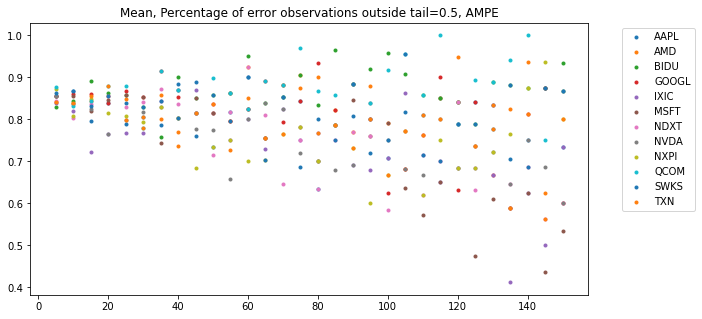

In [24]:
# dot plot, mean, tail = 50%
plotdot_mean(meanAMPE, 5, 150, 5, 0.5)

ticker  AAPL       AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  \
5        1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
10       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
15       1.0  0.993976   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
20       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
25       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
30       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
35       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
40       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
45       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
50       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
55       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
60       1.0  1.000000   1.0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=100, AMPE'}>)

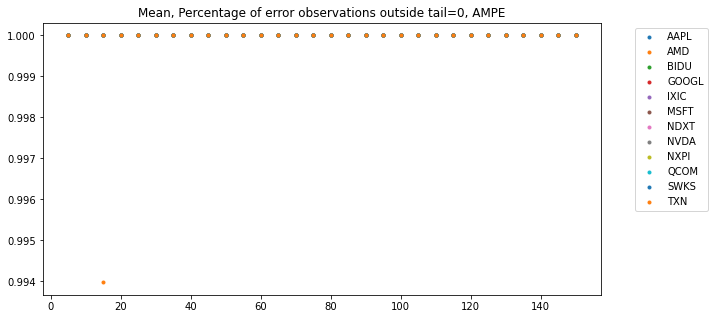

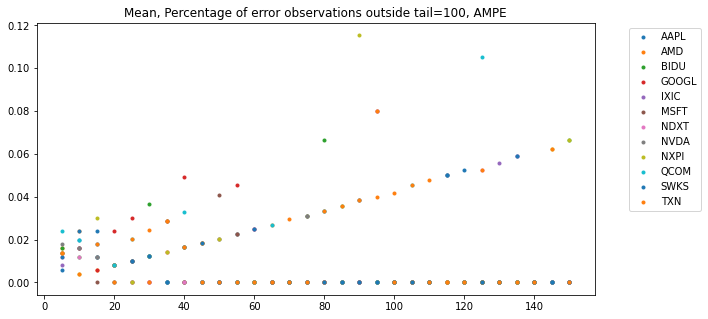

In [25]:
# dot plot, mean, tail = 0, 100 (for checking)
plotdot_mean(meanAMPE, 5, 150, 5, 0)
plotdot_mean(meanAMPE, 5, 150, 5, 100)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
10       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
15       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
20       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
25       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
30       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
35       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
40       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
45       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
50       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
55       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
60       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=inf, AMPE'}>)

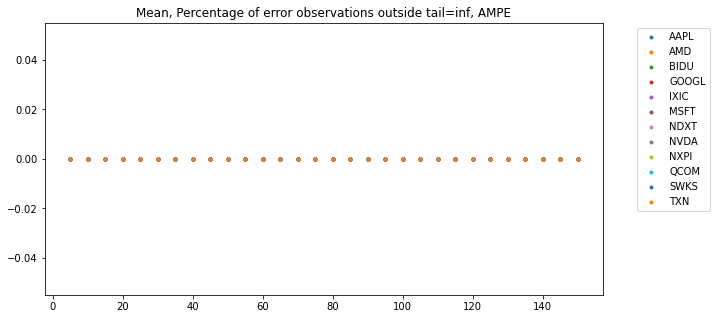

In [26]:
# dot plot, mean, tail = inf (for checking)
plotdot_mean(meanAMPE, 5, 150, 5, math.inf)

#### LAAR 

           LAAR (Volatility)                                          \
ticker                  AAPL       AMD      BIDU     GOOGL      IXIC   
Date                                                                   
2011-09-09          0.093822 -0.098541 -0.031312  0.357985  0.146891   
2011-12-19          0.232489  0.604367  0.408077  0.126319  0.826361   
2012-03-30         -0.369859 -0.273491  0.088607  0.041274 -0.409921   
2012-07-11          0.377079 -0.196272 -0.172905 -0.009898  0.381318   
2012-10-18         -0.672828 -0.125993  0.119812  0.156260 -0.099740   
2013-02-01          0.427762  0.211191 -0.065434  0.092555  0.083821   
2013-05-14          0.197329 -0.010546 -0.020267  0.170099  0.081104   
2013-08-22         -0.055326  0.210238  0.078215 -0.602567 -0.028389   
2013-12-02          0.010629  0.125083 -0.075449  0.383049 -0.080961   
2014-03-14          0.136805  0.000032  0.062540 -0.237226 -0.079901   
2014-06-24          0.076896 -0.068202  0.095702  0.326549  0.23

(None,
 array([[<AxesSubplot:title={'center':"('LAAR (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'TXN')"}>]],
       dtype=object))

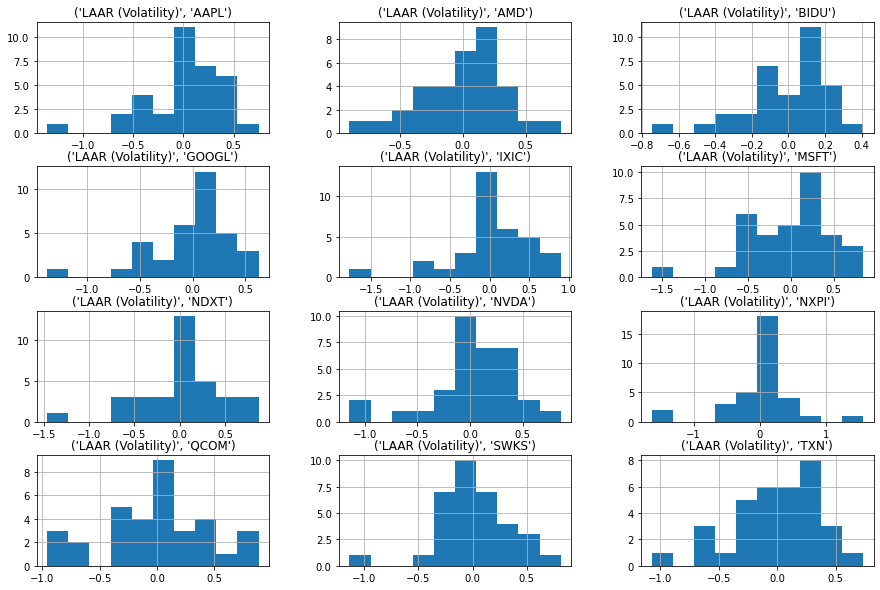

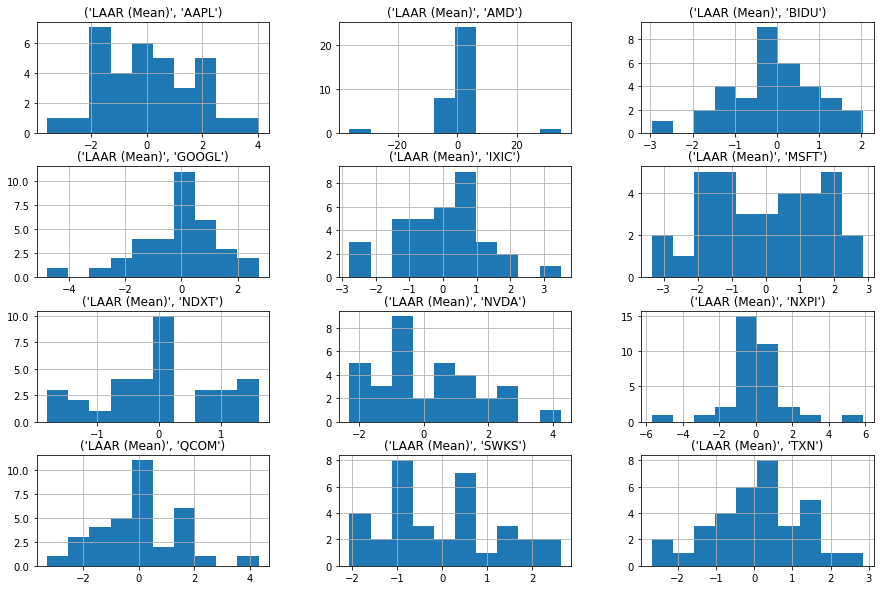

In [27]:
# histogram, tw = 70
plothist(volLAAR, 70)
plothist(meanLAAR, 70)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC      MSFT  NDXT  NVDA  NXPI      QCOM  \
5        0.0  0.0   0.0    0.0   0.0  0.001992   0.0   0.0   0.0  0.001992   
10       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
15       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
20       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
25       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
30       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
35       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
40       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
45       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
50       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
55       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0  0.000000   
60       0.0  0.0   0.0    0.0   0.0  0.000000   0.0   0.0   0.0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=2.4596031111569494, LAAR'}>)

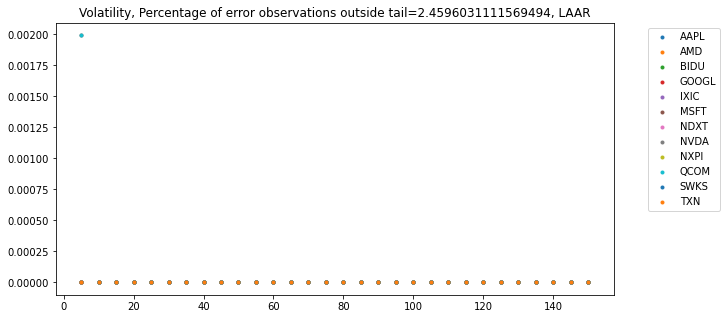

In [28]:
# dot plot, volatility, tail = e^0.9
plotdot_vol(volLAAR, 5, 150, 5, math.e**0.9)

ticker     AAPL       AMD      BIDU    GOOGL      IXIC      MSFT      NDXT  \
5       0.00996  0.017928  0.013944  0.00996  0.005976  0.015936  0.003984   
10      0.00000  0.012000  0.000000  0.00000  0.000000  0.000000  0.000000   
15      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
20      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
25      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
30      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
35      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
40      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
45      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
50      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
55      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
60      0.00000  0.000000  0.000000  0.00000  0.000000  0.000000

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=1.6487212707001282, LAAR'}>)

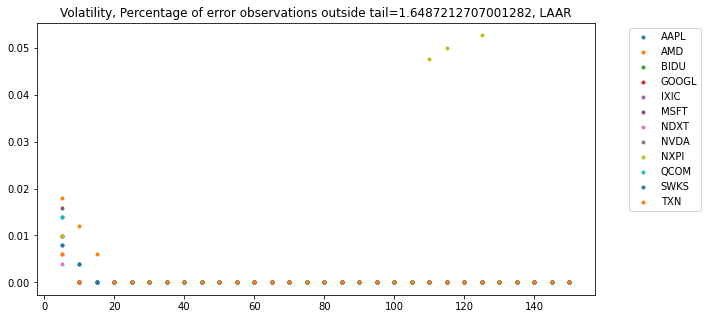

In [29]:
# dot plot, volatility, tail = e^0.5
plotdot_vol(volLAAR, 5, 150, 5, math.e**0.5)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
10       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
15       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
20       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
25       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
30       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
35       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
40       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
45       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
50       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
55       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
60       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=-inf, LAAR'}>)

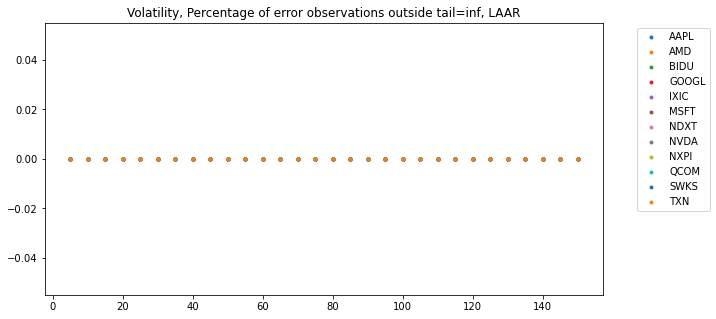

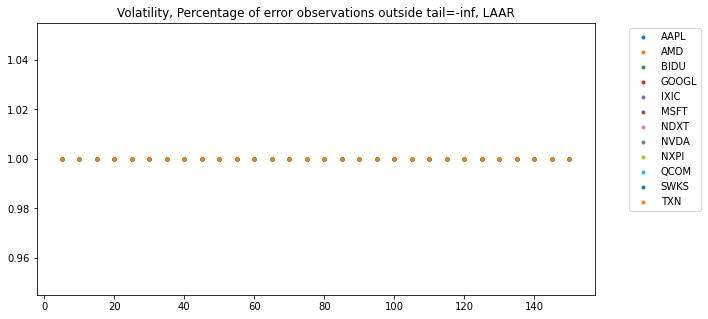

In [30]:
# dot plot, volatility, tail = +/-inf (for checking)
plotdot_vol(volLAAR, 5, 150, 5, math.inf)
plotdot_vol(volLAAR, 5, 150, 5, -math.inf)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.049801  0.053785  0.069721  0.047809  0.041833  0.061753  0.055777   
10      0.060000  0.060000  0.076000  0.072000  0.040000  0.060000  0.052000   
15      0.042169  0.054217  0.048193  0.084337  0.048193  0.060241  0.066265   
20      0.040323  0.048387  0.072581  0.064516  0.064516  0.040323  0.048387   
25      0.070707  0.050505  0.080808  0.050505  0.030303  0.070707  0.050505   
30      0.097561  0.060976  0.073171  0.048780  0.060976  0.024390  0.048780   
35      0.071429  0.085714  0.028571  0.100000  0.085714  0.042857  0.057143   
40      0.065574  0.081967  0.049180  0.049180  0.065574  0.049180  0.049180   
45      0.092593  0.092593  0.074074  0.037037  0.055556  0.018519  0.037037   
50      0.061224  0.061224  0.061224  0.040816  0.061224  0.040816  0.061224   
55      0.045455  0.068182  0.045455  0.068182  0.022727  0.045455  0.068182   
60      0.100000  0.050000  0.100000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=2.4596031111569494, LAAR'}>)

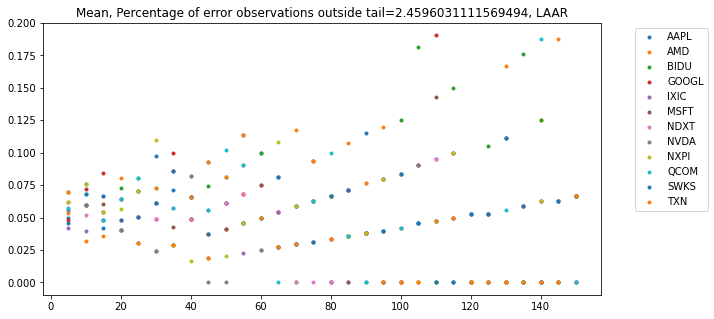

In [31]:
# dot plot, mean, tail = e^0.9
plotdot_mean(meanLAAR, 5, 150, 5, math.e**0.9)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.131474  0.127490  0.127490  0.109562  0.127490  0.127490  0.121514   
10      0.120000  0.124000  0.144000  0.156000  0.096000  0.128000  0.100000   
15      0.102410  0.138554  0.150602  0.162651  0.108434  0.132530  0.108434   
20      0.112903  0.129032  0.145161  0.145161  0.112903  0.129032  0.112903   
25      0.131313  0.090909  0.171717  0.111111  0.090909  0.131313  0.131313   
30      0.158537  0.146341  0.121951  0.097561  0.109756  0.109756  0.121951   
35      0.100000  0.100000  0.100000  0.185714  0.142857  0.085714  0.128571   
40      0.196721  0.114754  0.147541  0.114754  0.114754  0.081967  0.114754   
45      0.203704  0.166667  0.166667  0.111111  0.111111  0.111111  0.074074   
50      0.142857  0.142857  0.102041  0.142857  0.183673  0.183673  0.102041   
55      0.181818  0.204545  0.090909  0.136364  0.068182  0.181818  0.136364   
60      0.150000  0.075000  0.175000  0.

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=1.6487212707001282, LAAR'}>)

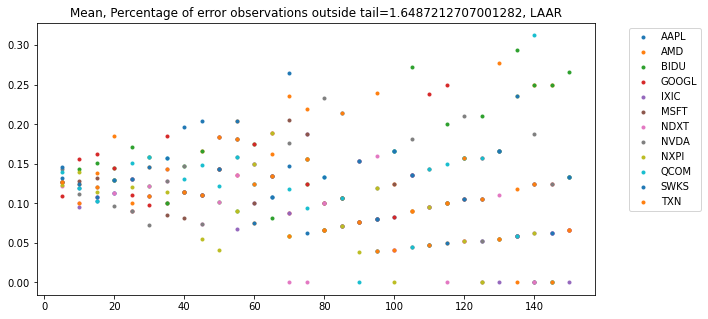

In [32]:
# dot plot, volatility, tail = e^0.5
plotdot_mean(meanLAAR, 5, 150, 5, math.e**0.5)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
10       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
15       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
20       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
25       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
30       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
35       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
40       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
45       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
50       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
55       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
60       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=-inf, LAAR'}>)

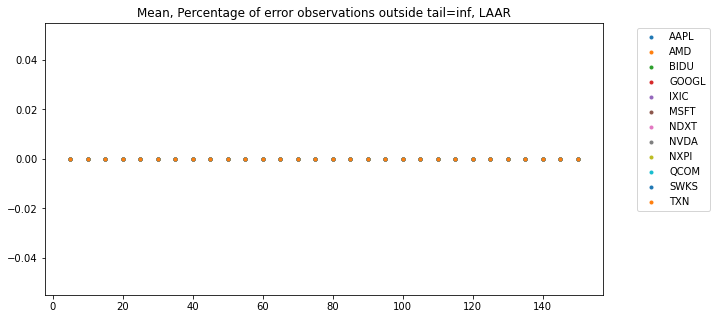

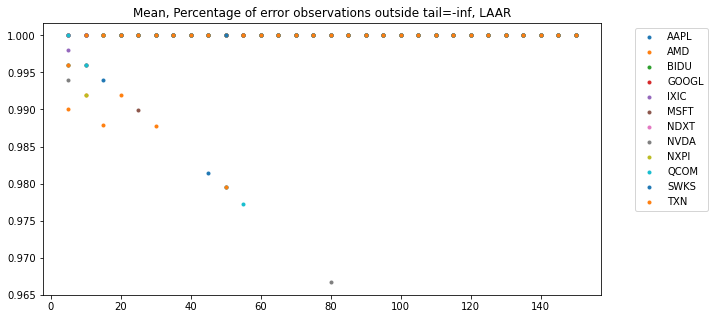

In [33]:
# dot plot, volatility, tail = +/-inf (for checking)
plotdot_mean(meanLAAR, 5, 150, 5, math.inf)
plotdot_mean(meanLAAR, 5, 150, 5, -math.inf)